In [1]:
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()

data_dir = Path.cwd() / "data"

In [2]:
from langchain.document_loaders import PyPDFLoader

filename = "Allplan_2020_Manual.pdf"

loader = PyPDFLoader(f"{data_dir}/{filename}")

raw_data = loader.load()

In [3]:
texts = [page.page_content for page in raw_data]

texts = " ".join(texts)
texts = texts.replace("\n", "")

In [4]:
from chonkie import SentenceChunker

chunker = SentenceChunker(
    tokenizer="gpt2",            
    chunk_size=500,                 
    chunk_overlap=50,               
    min_sentences_per_chunk=1        
)

chunks = chunker(texts)

docs = [chunk.text for chunk in chunks]

print(len(docs))  # Should match the number of chunks

180


# GraphRAG

In [5]:
import numpy as np
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model_name="gemini-2.5-flash", temperature=0.1, thinking_budget=0)

embedding_model = VertexAIEmbeddings(
    model_name="text-embedding-005"
)

embeddings = embedding_model.embed_documents(docs)

print(len(embeddings))

embeddings = np.array(embeddings)

/Users/avosseler/Github_priv/graph-rag/.venv/lib/python3.12/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


180


In [6]:
from graph_rag import KnowledgeGraph

kg = KnowledgeGraph()

# Extract concepts for all chunks (batch)
concepts_per_chunk = kg.extract_concepts_batch(docs=docs)

# Create knowledge graph
G = kg.create_graph(
            embeddings=embeddings,
            docs=docs,
            concepts_per_chunk=concepts_per_chunk,
            k=5,
            metric="IP",
            save_dir=data_dir / "kg_graph",
            similarity_threshold=0.5,  # Only keep edges with cosine similarity >= 0.5
            concept_weight=0.3,  # 30% weight to concept overlap similarity metric
)

2025-10-31 23:00:36,871 - graph_rag - INFO - Initializing KnowledgeGraph 📈
2025-10-31 23:00:36,871 - graph_rag - INFO - Loading GLiNER NER model...


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/Users/avosseler/Github_priv/graph-rag/.venv/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Extracting concepts / NER: 100%|██████████| 2/2 [00:37<00:00, 18.62s/it]
2025-10-31 23:01:18,250 - graph_rag - INFO - Saving adjacency list to directory: /Users/avosseler/Github_priv/graph-rag/data/kg_graph
2025-10-31 23:01:18,251 - graph_rag - INFO - Building kNN graph: 180 nodes, k=5, metric=IP


  Applying threshold: IP >=0.5


Building edges: 100%|██████████| 180/180 [00:00<00:00, 19499.32it/s]

✓ Created 900 edges
  Saved to: /Users/avosseler/Github_priv/graph-rag/data/kg_graph/graph_adjlist.txt
  Distance stats: mean=0.884, std=0.036
  Distance range: [0.696, 0.995]
Graph topology with concept enhancement:
  Nodes: 180
  Edges: 585
  Avg degree: 6.50


Visualize graph:

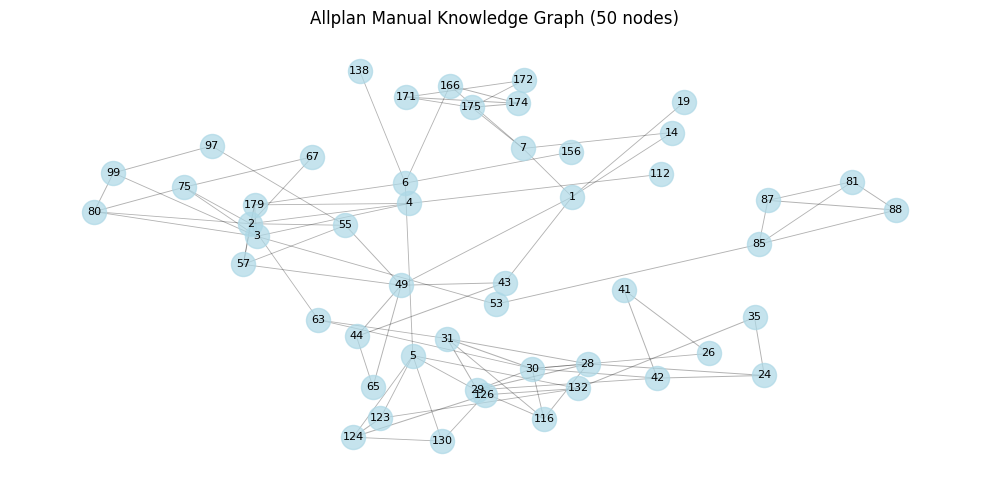

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

kg.visualize_graph_simple(G, max_nodes=50)

In [8]:
print("Nodes:", kg.nx_graph.number_of_nodes())
print("Edges:", kg.nx_graph.number_of_edges())

print("Sample nodes:", list(kg.nx_graph.nodes(data=True))[:3])
print("Sample edges:", list(kg.nx_graph.edges(data=True))[:3])

Nodes: 180
Edges: 585
Sample nodes: [(0, {'content': "Manual Installation, Basics ALLPLAN 2020 This documentation has been produced with the utmost care. ALLPLAN GmbH and the program authors have no liability to the purchaser or any other entity, with respect to any liability, loss, or damage caused, directly or indirectly by this software and its documentation, including but not limited to, any interruptions of service, loss of business, anticipatory profits, or consequential damages resulting from the use or operation of this software and its documentation. In the event of discrepancies between the descriptions and the program, the menu and program lines displayed by the program take precedence. Information in this documentation is subject to change without notice. Companies, names and data used in examples are fictitious unless otherwise noted. No part of this documentation may be reproduced or transmitted in any form or by means, electronic or mechanical, for any purpose, without t

## Create a single GraphDocument from nodes and relationships:
This will hold all nodes and therelationships extracted from networkX graph object.

In [10]:
# import networkx as nx
# from langchain_core.documents import Document
# from langchain_community.graphs.graph_document import Node, Relationship, GraphDocument

# # 1. Convert nodes
# lc_nodes = []
# node_lookup = {}  # To reuse Node objects in relationships

# for node_id, attrs in kg.nx_graph.nodes(data=True):
#     node_type = attrs.get("type", "Node")
#     properties = {k: v for k, v in attrs.items() if k != "type"}
#     node = Node(id=str(node_id), type=node_type, properties=properties)
#     lc_nodes.append(node)
#     node_lookup[str(node_id)] = node

# # 2. Convert edges using Node objects
# lc_relationships = []
# for source, target, attrs in kg.nx_graph.edges(data=True):
#     rel_type = attrs.get("type", "RELATED_TO")
#     properties = {k: v for k, v in attrs.items() if k != "type"}
    
#     source_node = node_lookup[str(source)]
#     target_node = node_lookup[str(target)]
    
#     lc_relationships.append(
#         Relationship(
#             source=source_node,
#             target=target_node,
#             type=rel_type,
#             properties=properties,
#         )
#     )

# # 3. Create a Document for the source
# source_doc = Document(
#     page_content="NetworkX graph conversion",  # Or any meaningful content
#     metadata={"source": "networkx_graph"}  # Optional metadata
# )

# # 4. Construct GraphDocument
# graph_doc = GraphDocument(
#     nodes=lc_nodes,
#     relationships=lc_relationships,
#     source=source_doc
# )

# graph_documents_filtered = [graph_doc]  # Assuming we have only one graph document here

In [78]:
# from google.cloud import spanner

# spanner_client = spanner.Client()
# instance = spanner_client.instance(SPANNER_INSTANCE_ID)
# database = instance.database(SPANNER_DATABASE_ID)

# operation = database.update_ddl([
#     """
#     CREATE TABLE KgEdge (
#       SourceId    INT64 NOT NULL,
#       TargetId    INT64 NOT NULL,
#       Type        STRING(128),
#       Properties  STRING(MAX)
#     ) PRIMARY KEY (SourceId, TargetId)
#     """
# ])
# operation.result()  # Wait for completion
# print("KgEdge table created.")

In [12]:
# --- 1. Convert nodes for GraphDocument and prepare Spanner rows ---
import networkx as nx
from langchain_core.documents import Document
from langchain_community.graphs.graph_document import Node, Relationship, GraphDocument
import json

lc_nodes = []
node_lookup = {}  # To reuse Node objects in relationships
spanner_node_rows = []

for node_id, attrs in kg.nx_graph.nodes(data=True):
    node_type = attrs.get("type", "Node")
    properties = {k: v for k, v in attrs.items() if k != "type"}
    node = Node(id=str(node_id), type=node_type, properties=properties)
    lc_nodes.append(node)
    node_lookup[str(node_id)] = node

    # Prepare Spanner node row
    spanner_node_rows.append({
        "NodeId": int(node_id),
        "Type": node_type,
        "Content": attrs.get("content", ""),
        "Embedding": attrs.get("embedding", []),
        "Concepts": attrs.get("concepts", []),
        "DegCentrality": attrs.get("deg_centrality", 0.0),
        "Closeness": attrs.get("closeness_centrality", 0.0),
        "Betweenness": attrs.get("betweenness_centrality", 0.0),
        "Eigenvector": attrs.get("eigenvector_centrality", 0.0),
    })

# --- 2. Convert edges for GraphDocument and prepare Spanner rows (undirected/weighted) ---
lc_relationships = []
spanner_edge_rows = []

for source, target, attrs in kg.nx_graph.edges(data=True):
    rel_type = attrs.get("type", "RELATED_TO")
    properties = {k: v for k, v in attrs.items() if k != "type"}
    # Add weight to properties if present
    if "weight" in attrs:
        properties["weight"] = attrs["weight"]

    source_node = node_lookup[str(source)]
    target_node = node_lookup[str(target)]

    # Add both directions for undirected graph
    for src, tgt in [(source, target), (target, source)]:
        lc_relationships.append(
            Relationship(
                source=node_lookup[str(src)],
                target=node_lookup[str(tgt)],
                type=rel_type,
                properties=properties,
            )
        )
        spanner_edge_rows.append({
            "SourceId": int(src),
            "TargetId": int(tgt),
            "Type": rel_type,
            "Properties": json.dumps(properties),
        })

# --- 3. Create a Document for the source ---
source_doc = Document(
    page_content="NetworkX graph conversion",
    metadata={"source": "networkx_graph"}
)

# --- 4. Construct GraphDocument ---
graph_doc = GraphDocument(
    nodes=lc_nodes,
    relationships=lc_relationships,
    source=source_doc
)

graph_documents_filtered = [graph_doc]

In [13]:
# Diagnostic check
print("="*50)
print("DIAGNOSTICS")
print("="*50)
print(f"NetworkX graph type: {type(kg.nx_graph)}")
print(f"Nodes: {kg.nx_graph.number_of_nodes()}")
print(f"Edges: {kg.nx_graph.number_of_edges()}")
print(f"\nlc_nodes count: {len(lc_nodes)}")
print(f"lc_relationships count: {len(lc_relationships)}")
print(f"\nGraphDocument:")
print(f"  - nodes: {len(graph_doc.nodes)}")
print(f"  - relationships: {len(graph_doc.relationships)}")
print(f"  - source: {graph_doc.source}")

if lc_nodes:
    print(f"\nSample Node: {lc_nodes[0]}")
if lc_relationships:
    print(f"\nSample Relationship: {lc_relationships[0]}")


DIAGNOSTICS
NetworkX graph type: <class 'networkx.classes.graph.Graph'>
Nodes: 180
Edges: 585

lc_nodes count: 180
lc_relationships count: 1170

GraphDocument:
  - nodes: 180
  - relationships: 1170
  - source: page_content='NetworkX graph conversion' metadata={'source': 'networkx_graph'}

Sample Node: id='0' properties={'content': "Manual Installation, Basics ALLPLAN 2020 This documentation has been produced with the utmost care. ALLPLAN GmbH and the program authors have no liability to the purchaser or any other entity, with respect to any liability, loss, or damage caused, directly or indirectly by this software and its documentation, including but not limited to, any interruptions of service, loss of business, anticipatory profits, or consequential damages resulting from the use or operation of this software and its documentation. In the event of discrepancies between the descriptions and the program, the menu and program lines displayed by the program take precedence. Information 

In [30]:
graph_documents_filtered[0].nodes[:5]

[Node(id='0', properties={'content': "Manual Installation, Basics ALLPLAN 2020 This documentation has been produced with the utmost care. ALLPLAN GmbH and the program authors have no liability to the purchaser or any other entity, with respect to any liability, loss, or damage caused, directly or indirectly by this software and its documentation, including but not limited to, any interruptions of service, loss of business, anticipatory profits, or consequential damages resulting from the use or operation of this software and its documentation. In the event of discrepancies between the descriptions and the program, the menu and program lines displayed by the program take precedence. Information in this documentation is subject to change without notice. Companies, names and data used in examples are fictitious unless otherwise noted. No part of this documentation may be reproduced or transmitted in any form or by means, electronic or mechanical, for any purpose, without the express writt

In [15]:
#graph_documents_filtered[0].relationships

In [ ]:
GCP_PROJECT_ID = "neme-ai-rnd-dev-prj-01"
REGION = "europe-west3" 
# MODEL_NAME = "gemini-2.0-flash"  
# EMBEDDING_MODEL_NAME = "text-embedding-005"  
TASK_TYPE = "SEMANTIC_SIMILARITY" 
ANSWER_TASK_TYPE = "RETRIEVAL_DOCUMENT"  
SPANNER_INSTANCE_ID = "graphrag-instance-new"  
SPANNER_DATABASE_ID = "graphrag-new"  
SPANNER_GRAPH_NAME = "Allplan"

In [26]:
from google.cloud import spanner

spanner_client = spanner.Client()
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)

with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        "SELECT table_name FROM information_schema.tables WHERE table_catalog = '' AND table_schema = '';"
    )
    for row in results:
        print(row[0])

Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.


Allplan_Node
Allplan_Node_RELATED_TO_Node
KgEdge
KgNode
Node
Node_RELATED_TO_Node


Drop tables:

In [29]:
# from google.cloud import spanner

# spanner_client = spanner.Client()
# instance = spanner_client.instance(SPANNER_INSTANCE_ID)
# database = instance.database(SPANNER_DATABASE_ID)

# table_name1 = "Allplan_Node"
# table_name2 = "Allplan_Node_RELATED_TO_Node"

# operation = database.update_ddl([
#     f"DROP TABLE {table_name2}",  # Drop child first
#     f"DROP TABLE {table_name1}",  # Then parent
# ])
# operation.result()  # Wait for completion
# print("Tables KgNode and KgEdge dropped.")

Create tables:

In [ ]:
from google.cloud import spanner

spanner_client = spanner.Client()
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)

operation = database.update_ddl([
    """
    CREATE TABLE KgNode (
        NodeId        INT64 NOT NULL,
        Type          STRING(128),
        Content       STRING(MAX),
        Embedding     ARRAY<FLOAT64>,
        Concepts      ARRAY<STRING(MAX)>,
        DegCentrality FLOAT64,
        Closeness     FLOAT64,
        Betweenness   FLOAT64,
        Eigenvector   FLOAT64
    ) PRIMARY KEY (NodeId)
    """,
    """
    CREATE TABLE KgEdge (
        SourceId   INT64 NOT NULL,
        TargetId   INT64 NOT NULL,
        Type       STRING(128),
        Properties STRING(MAX)
    ) PRIMARY KEY (SourceId, TargetId)
    """
])
operation.result()  # Wait for completion
print("Tables KgNode and KgEdge created.")

Tables KgNode and KgEdge created.


Insert / Replace table data:

In [18]:
# --- 5. Robust Spanner ingestion ---
from google.cloud import spanner

spanner_client = spanner.Client()
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)

# Ensure all keys are present in every row (robust against missing attributes)
spanner_node_rows_fixed = []
for row in spanner_node_rows:
    spanner_node_rows_fixed.append({
        "NodeId": row.get("NodeId", 0),
        "Type": row.get("Type", "Node"),
        "Content": row.get("Content", ""),
        "Embedding": row.get("Embedding", []),
        "Concepts": row.get("Concepts", []),
        "DegCentrality": row.get("DegCentrality", 0.0),
        "Closeness": row.get("Closeness", 0.0),
        "Betweenness": row.get("Betweenness", 0.0),
        "Eigenvector": row.get("Eigenvector", 0.0),
    })

spanner_edge_rows_fixed = []
for row in spanner_edge_rows:
    spanner_edge_rows_fixed.append({
        "SourceId": row.get("SourceId", 0),
        "TargetId": row.get("TargetId", 0),
        "Type": row.get("Type", "RELATED_TO"),
        "Properties": row.get("Properties", "{}"),
    })

with database.batch() as batch:
    batch.replace(
        table="KgNode",
        columns=["NodeId", "Type", "Content", "Embedding", "Concepts", "DegCentrality", "Closeness", "Betweenness", "Eigenvector"],
        values=[
            (
                row["NodeId"], row["Type"], row["Content"], row["Embedding"], row["Concepts"],
                row["DegCentrality"], row["Closeness"], row["Betweenness"], row["Eigenvector"]
            ) for row in spanner_node_rows_fixed
        ]
    )
    batch.replace(
        table="KgEdge",
        columns=["SourceId", "TargetId", "Type", "Properties"],
        values=[
            (
                row["SourceId"], row["TargetId"], row["Type"], row["Properties"]
            ) for row in spanner_edge_rows_fixed
        ]
    )

Created multiplexed session.
Created multiplexed session.


In [43]:
# !gcloud services enable spanner.googleapis.com
# !gcloud spanner instances create {SPANNER_INSTANCE_ID} --config=regional-europe-west3 --description="Graph RAG Instance" --nodes=1 --edition=ENTERPRISE

In [ ]:
# # prompt: create a spanner database and table to store the graph with nodes and edges created in graph

# def create_database(project_id, instance_id, database_id):
#     """Creates a database and tables for sample data."""
#     from google.cloud import spanner
#     from google.cloud.spanner_admin_database_v1.types import spanner_database_admin

#     spanner_client = spanner.Client(project_id)
#     database_admin_api = spanner_client.database_admin_api

#     request = spanner_database_admin.CreateDatabaseRequest(
#         parent=database_admin_api.instance_path(spanner_client.project, instance_id),
#         create_statement=f"CREATE DATABASE `{database_id}`",
#         extra_statements=[
#             """CREATE TABLE KgNode (
#             DocId        INT64 NOT NULL,
#             Name STRING(1024),
#             DOC STRING(1024),
#             DocEmbedding ARRAY<FLOAT64>
#             ) PRIMARY KEY (DocId)"""
#         ],
#     )

#     operation = database_admin_api.create_database(request=request)

#     print("Waiting for operation to complete...")
#     OPERATION_TIMEOUT_SECONDS = 60
#     database = operation.result(OPERATION_TIMEOUT_SECONDS)

#     print(
#         f"Created database {database.name} on instance {database_admin_api.instance_path(spanner_client.project, instance_id)}"
#     )

def create_database(project_id, instance_id, database_id):
    """Creates a database and tables for graph data."""
    from google.cloud import spanner
    from google.cloud.spanner_admin_database_v1.types import spanner_database_admin

    spanner_client = spanner.Client(project_id)
    database_admin_api = spanner_client.database_admin_api

    request = spanner_database_admin.CreateDatabaseRequest(
        parent=database_admin_api.instance_path(spanner_client.project, instance_id),
        create_statement=f"CREATE DATABASE `{database_id}`",
        extra_statements=[
            """
            CREATE TABLE KgNode (
                NodeId        INT64 NOT NULL,
                Type          STRING(128),
                Content       STRING(MAX),
                Embedding     ARRAY<FLOAT64>,
                Concepts      ARRAY<STRING(MAX)>,
                DegCentrality FLOAT64,
                Closeness     FLOAT64,
                Betweenness   FLOAT64,
                Eigenvector   FLOAT64
            ) PRIMARY KEY (NodeId)
            """,
            """
            CREATE TABLE KgEdge (
                SourceId   INT64 NOT NULL,
                TargetId   INT64 NOT NULL,
                Type       STRING(128),
                Properties STRING(MAX)
            ) PRIMARY KEY (SourceId, TargetId)
            """
        ],
    )

    operation = database_admin_api.create_database(request=request)
    print("Waiting for operation to complete...")
    OPERATION_TIMEOUT_SECONDS = 60
    database = operation.result(OPERATION_TIMEOUT_SECONDS)
    print(
        f"Created database {database.name} on instance {database_admin_api.instance_path(spanner_client.project, instance_id)}"
    )

In [21]:
# create_database(GCP_PROJECT_ID, SPANNER_INSTANCE_ID, SPANNER_DATABASE_ID)

In [2]:
from langchain_google_spanner import SpannerGraphStore

graph_store = SpannerGraphStore(
    instance_id=SPANNER_INSTANCE_ID,
    database_id=SPANNER_DATABASE_ID,
    graph_name=SPANNER_GRAPH_NAME,
)

Created multiplexed session.


In [3]:
graph_store.get_structured_schema

{'Name of graph': 'Allplan',
 'Node properties per node label': {'Node': [{'name': 'concepts',
    'type': 'ARRAY<STRING>'},
   {'name': 'content', 'type': 'STRING'},
   {'name': 'embedding', 'type': 'ARRAY<FLOAT64>'},
   {'name': 'id', 'type': 'STRING'}]},
 'Edge properties per edge label': {'Node_RELATED_TO_Node': [{'name': 'id',
    'type': 'STRING'},
   {'name': 'shared_concepts', 'type': 'ARRAY<STRING>'},
   {'name': 'target_id', 'type': 'STRING'},
   {'name': 'weight', 'type': 'FLOAT64'}]},
 'Possible edges per label': {'Node_RELATED_TO_Node': ['(:Node) -[:Node_RELATED_TO_Node]-> (:Node)']}}

Add graph data to Spanner:

In [21]:
# Uncomment the line below, if you want to cleanup from previous iterations.
# BeWARE - THIS COULD REMOVE DATA FROM YOUR DATABASE !!!

graph_store.cleanup()

for graph_document in graph_documents_filtered:
    graph_store.add_graph_documents([graph_document])

Waiting for DDL operations to complete...
Waiting for DDL operations to complete...
Waiting for DDL operations to complete...
Waiting for DDL operations to complete...
Insert nodes of type `Node`...
Insert nodes of type `Node`...
Insert edges of type `Node_RELATED_TO_Node`...
Insert edges of type `Node_RELATED_TO_Node`...


In [ ]:
# from langchain_google_spanner import SpannerGraphQAChain
# from langchain_google_vertexai import ChatVertexAI

# # Initialize llm object
# llm = ChatVertexAI(model=MODEL_NAME, temperature=0)

# # Initialize GraphQAChain
# chain = SpannerGraphQAChain.from_llm(
#     llm,
#     graph=graph_store,
#     allow_dangerous_requests=True,
#     # verbose=True,               # show intermediate steps
#     return_intermediate_steps=True,
# )

In [61]:
# question = "What is Allplan?"  
# question = "How can I configure the Actionbar in Allplan?"

# response = chain.invoke(input=question)

# print(response["result"])

In [17]:
with database.snapshot() as snapshot:
    results = list(snapshot.execute_sql("SELECT NodeId, Content FROM KgNode LIMIT 10"))
    for node_id, content in results:
        print(f"NodeId: {node_id}, Content: {content[:100]}")

NodeId: 0, Content: Manual Installation, Basics ALLPLAN 2020 This documentation has been produced with the utmost care. 
NodeId: 1, Content: All other (registered) trademarks are the property of their respective owners.  © ALLPLAN GmbH, Muni
NodeId: 2, Content: 75 Shortcut menu ...................................................................................
NodeId: 3, Content: 119 Layers and format properties ...................................................................
NodeId: 4, Content: 170 Using elements from wizards.....................................................................
NodeId: 5, Content: ................................ ... 207 Using OLE objects .........................................
NodeId: 6, Content: 242 Using print sets ...............................................................................
NodeId: 7, Content: 287 Components of a layout .........................................................................
NodeId: 8, Content: • The Basics

In [29]:
# steps = response.get("intermediate_steps", [])

# for step in steps:
#     if isinstance(step, dict) and "context" in step:
#         print("\n--- Retrieved Content ---")
#         for doc in step["context"]:
#             print(doc["content"])
#             print("-" * 40)

In [21]:
from langchain_google_spanner import SpannerGraphStore, SpannerGraphVectorContextRetriever
from langchain_google_vertexai import ChatVertexAI, VertexAIEmbeddings

# question = "What is Allplan?"  
question = "How can I configure the Actionbar in Allplan?"

embedding_service = VertexAIEmbeddings(model_name="text-embedding-005")

retriever = SpannerGraphVectorContextRetriever.from_params(
    graph_store=graph_store,
    embedding_service=embedding_service,
    embeddings_column="Embedding",
    top_k=5,           # Number of vector similarity matches to return
    k=3,               # Number of graph results to return
    return_properties_list=["id", "content"],
    expand_by_hops=-1  # or set return_properties_list=["NodeId", "Content"] and expand_by_hops=-1
)

results = retriever.invoke(question)
results

/Users/avosseler/Github_priv/graph-rag/.venv/lib/python3.12/site-packages/vertexai/_model_garden/_model_garden_models.py:278: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


[Document(metadata={}, page_content='{"id": "19", "content": "When you install for the first time or work with the Actionbar Configuration, the menu bar is hidden by default. You can show or hide the menu bar on the Quick Access Toolbar  (on page 21). Use the ALT KEY to show the menu bar for a short time. All the tools can be activated via the menus, regardless of the role or task you are working on.   Tip: To open a menu, you can also select the underlined letter in the menu name while selecting and holding the Alt key. 24 Actionbar Allplan 2020  Actionbar You can find the Actionbar  above the workspace (see \\"Working area\\" on page 19).  The Actionbar  contains all Allplan tools in groups of tools. The groups of tools are combined into task areas, which are combined into tasks. You can find the tasks required for each discipline in a role. To see the Actionbar , you must select the Actionbar Configuration. You can show or hide the Actionbar at any time Note : To find out which tool

In [24]:
from langchain.chains import RetrievalQA
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model_name="gemini-2.5-flash", temperature=0.1, thinking_budget=0)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
)
response = qa_chain.invoke({"query": question})
print(response["result"])

You can configure the Actionbar in Allplan using the **Actionbar Configurator**.

Here's how:
1.  Locate the **Actionbar Configurator** on the right side of the Actionbar.
2.  Click the icon to open the **Actionbar Configuration** dialog box.
3.  In the **Configure** tab, you can choose to:
    *   Create a new role.
    *   Select and modify an existing role.
4.  If creating a new role, you can base it on a template (like the program's default roles) or start with an empty template.
5.  To design the role, you can:
    *   Move, delete, or add elements using drag-and-drop.
    *   Double-click a task or task area to change its name.
    *   Create flyout menus by dragging a tool's icon onto another tool.
6.  After making your changes, save the new role. Allplan automatically saves all available roles in the `\Usr\Local\Actionbar` folder as a `configuration.actb` file.


Visualize the full knowledge graph from Spanner using NetworkX:

Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.
Created multiplexed session.


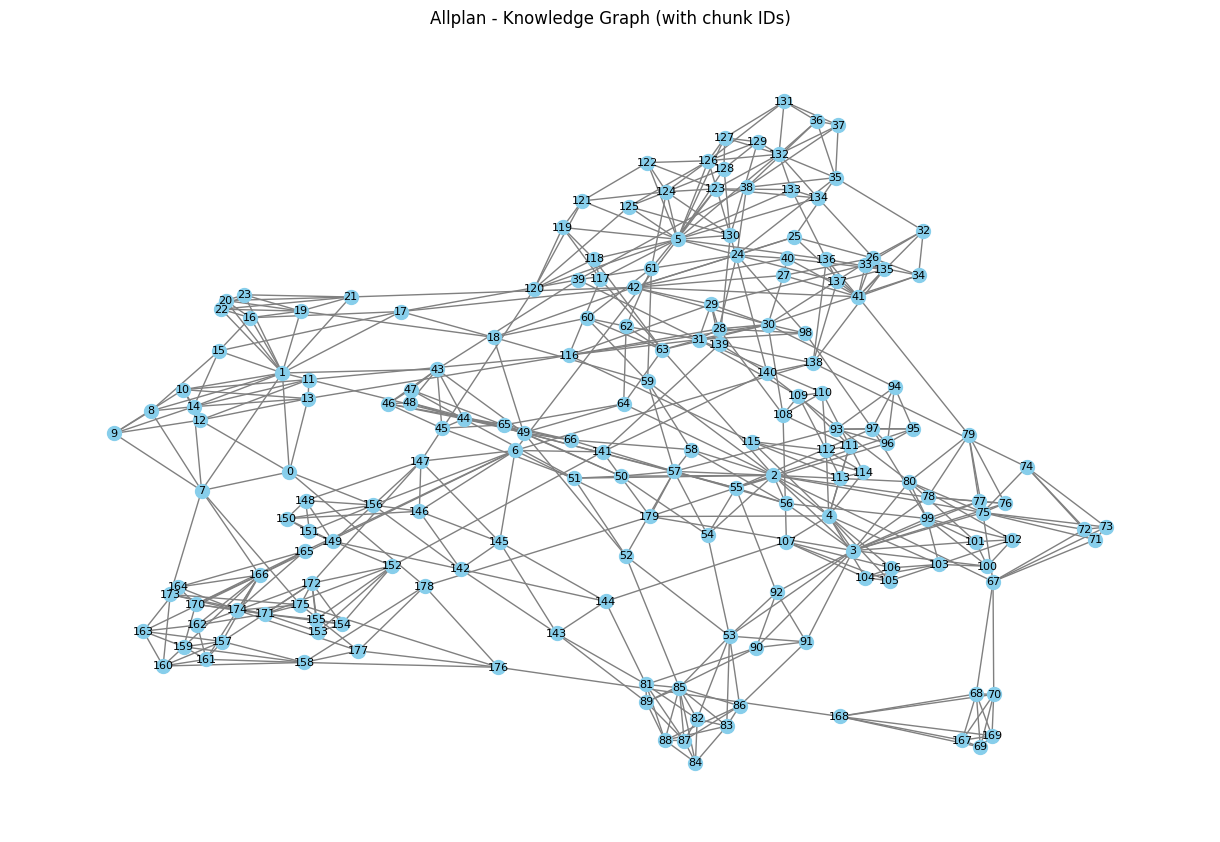

In [25]:
# Visualize the full knowledge graph from Spanner with node IDs as labels

import networkx as nx
import matplotlib.pyplot as plt
from google.cloud import spanner

spanner_client = spanner.Client()
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)

# Fetch nodes
with database.snapshot() as snapshot:
    node_rows = list(snapshot.execute_sql("SELECT NodeId FROM KgNode"))
    nodes = [row[0] for row in node_rows]

# Fetch edges (unique undirected)
with database.snapshot() as snapshot:
    edge_rows = list(snapshot.execute_sql("""
        SELECT DISTINCT LEAST(SourceId, TargetId) AS n1, GREATEST(SourceId, TargetId) AS n2
        FROM KgEdge
    """))
    edges = [(row[0], row[1]) for row in edge_rows if row[0] != row[1]]

# Build the NetworkX graph
G_full = nx.Graph()
G_full.add_nodes_from(nodes)
G_full.add_edges_from(edges)

# Visualize the full graph with node IDs as labels
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_full, seed=42)
nx.draw(
    G_full, pos,
    node_size=100,
    node_color="skyblue",
    edge_color="gray",
    with_labels=False
)
nx.draw_networkx_labels(G_full, pos, labels={n: str(n) for n in G_full.nodes()}, font_size=8)
plt.title("Allplan - Knowledge Graph (with chunk IDs)")
plt.axis("off")
plt.show();

In [59]:
# with database.snapshot() as snapshot:
#     results = list(snapshot.execute_sql("SELECT NodeId, Content FROM KgNode LIMIT 10"))
#     for node_id, content in results:
#         print(f"NodeId: {node_id}, Content: {content[:100]}")

In [60]:
# from langchain_google_spanner import SpannerGraphTextToGQLRetriever

# retriever = SpannerGraphTextToGQLRetriever.from_params(
#     graph_store=graph_store,
#     # embedding_service=embedding_service,
#     # embeddings_column="Embedding",
#     text_column="Concepts",  # Use the Content column for keyword search
#     llm=llm
# )

# results = retriever.invoke(question)
# results

In [ ]:
# GRAPH Allplan
# MATCH p = (a)-[e]->(b)
# RETURN TO_JSON(p) AS path_json

In [61]:
import numpy as np
from google.cloud import spanner

# 1. Embed the query
#question = "How do I configure the Actionbar?"

query_embedding = embedding_model.embed_query(question)  # shape: (embedding_dim,)

# 2. Fetch all node embeddings and IDs from Spanner
with database.snapshot() as snapshot:
    results = list(snapshot.execute_sql(
        "SELECT NodeId, Content, Embedding FROM KgNode"
    ))

# 3. Compute similarity in Python
def cosine_similarity(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

scored_nodes = []
for node_id, content, embedding in results:
    if embedding:  # skip if embedding is empty
        score = cosine_similarity(query_embedding, embedding)
        scored_nodes.append((score, node_id, content))

# 4. Sort and get top-k
top_k = 5
top_nodes = sorted(scored_nodes, reverse=True)[:top_k]

for score, node_id, content in top_nodes:
    print(f"NodeId: {node_id}, Score: {score:.3f}, Content: {content[:100]}")

NodeId: 8, Score: 0.707, Content: • The Basics Tutorial  guides you step by step through the most important tools for designing and mo
NodeId: 7, Score: 0.705, Content: 287 Components of a layout .........................................................................
NodeId: 0, Score: 0.691, Content: Manual Installation, Basics ALLPLAN 2020 This documentation has been produced with the utmost care. 
NodeId: 132, Score: 0.689, Content: However, you can also use the lower and upper default planes from different pairs of planes. Thus, y
NodeId: 1, Score: 0.683, Content: All other (registered) trademarks are the property of their respective owners.  © ALLPLAN GmbH, Muni


In [62]:
with database.snapshot() as snapshot:
    results = list(snapshot.execute_sql("SELECT NodeId, Embedding FROM KgNode LIMIT 5"))
    for node_id, embedding in results:
        print(f"NodeId: {node_id}, Embedding: {embedding[:5] if embedding else embedding}")

NodeId: 0, Embedding: [-0.03565193712711334, -0.00936036929488182, -0.04612285643815994, -0.029244549572467804, -0.006902330555021763]
NodeId: 1, Embedding: [-0.026510410010814667, -0.011906242929399014, -0.040696702897548676, -0.0049427528865635395, -0.023882634937763214]
NodeId: 2, Embedding: [-0.011281267739832401, 0.004595539066940546, -0.03310849517583847, -0.01801350712776184, -0.008526039309799671]
NodeId: 3, Embedding: [0.01663263700902462, 0.022231366485357285, -0.033822350203990936, -0.020499441772699356, 0.01633152924478054]
NodeId: 4, Embedding: [0.017211180180311203, 0.01518703531473875, -0.03875740244984627, -0.03118218667805195, -0.001142954919487238]


In [63]:
spanner_node_rows.append({
    "NodeId": int(node_id),
    "Type": node_type,
    "Content": attrs.get("content", ""),
    "Embedding": attrs.get("embedding", []),  # <-- This must be a real vector!
})
spanner_node_rows

[{'NodeId': 0,
  'Type': 'Node',
  'Content': "Manual Installation, Basics ALLPLAN 2020 This documentation has been produced with the utmost care. ALLPLAN GmbH and the program authors have no liability to the purchaser or any other entity, with respect to any liability, loss, or damage caused, directly or indirectly by this software and its documentation, including but not limited to, any interruptions of service, loss of business, anticipatory profits, or consequential damages resulting from the use or operation of this software and its documentation. In the event of discrepancies between the descriptions and the program, the menu and program lines displayed by the program take precedence. Information in this documentation is subject to change without notice. Companies, names and data used in examples are fictitious unless otherwise noted. No part of this documentation may be reproduced or transmitted in any form or by means, electronic or mechanical, for any purpose, without the expr

In [11]:
# kg.compute_centrality(G)

In [12]:
# Retrieve relevant subgraph for a user query
query = "How can I configure the Actionbar in Allplan?"

# 1.) Retrieve relevant nodes and neighborhood contexts
result = kg.retrieve(
    G=G,
    query=query,
    embedding_model=embedding_model,
    top_k=5,                 # number of semantic seed nodes
    k_hops=1,                # graph expansion radius
    text_attr="content",     # node attribute containing text
    centrality_weight=0.5    # weight of centrality in scoring
)

In [13]:
# # Inspect result
# print("Top-k nodes and scores:")
# for node_id, score in result.get("top-k-nodes", []):
#     print(f"  {node_id}: {score:.3f}")

# print("\nNodes in neighborhood:", result["neighborhood"])

# print("\nTexts passed to LLM:")
# for node_id, text in result["contexts"]:
#     print(f"- Node {node_id}: {text}")

# # Pass concatenated texts to your LLM
# context_text = "\n".join(t for _, t in result["contexts"])

# prompt = f"""
# Use the following context to answer the question.
# {context_text}
# Question: {query}
# Answer:
# """

# # 2.) Generate answer based on retrieved context:
# llm_response = llm.invoke(prompt)

# print(llm_response.content)

Show retrieved subgraph for query with top-k nodes ('seeds') in red and k-hop neighbors ('non-seeds') in blue

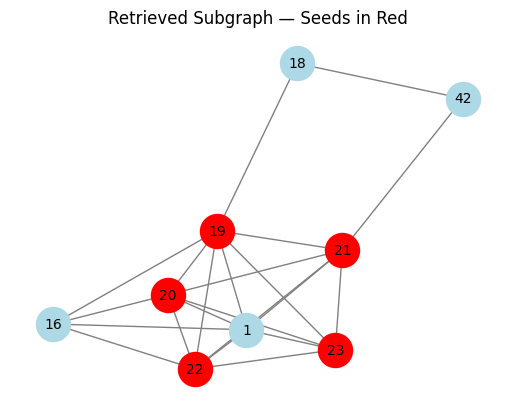

In [14]:
import matplotlib.pyplot as plt

SG = result["subgraph"]
seeds = [n for n, _ in result.get("top-k-nodes", [])]

pos = nx.spring_layout(SG, seed=42)

# draw edges
nx.draw_networkx_edges(SG, pos, edge_color="gray")

# draw non-seed nodes (light blue)
nx.draw_networkx_nodes(
    SG, pos,
    nodelist=[n for n in SG.nodes if n not in seeds],
    node_color="lightblue",
    node_size=600
)

# draw seed nodes (red)
nx.draw_networkx_nodes(
    SG, pos,
    nodelist=seeds,
    node_color="red",
    node_size=600
)

# draw node labels (indexes)
nx.draw_networkx_labels(SG, pos, labels={n: str(n) for n in SG.nodes()}, font_size=10)

plt.title("Retrieved Subgraph — Seeds in Red")
plt.axis("off")
plt.show()


### Langchain GraphRAG Pipeline

In [12]:
from graph_rag import GraphRAGRetriever

retriever = GraphRAGRetriever(
    kg=kg,
    embedding_model=embedding_model,
    top_k=5,
    k_hops=1,
)

In [13]:
from langchain.chains import RetrievalQA

docs = retriever.get_relevant_documents("How do I configure the Actionbar?")

for d in docs:
    print(d.metadata, d.page_content[:100])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
)

response = qa_chain.invoke({"query": "How do I configure the Actionbar in Allplan?"})
print(response["result"])


/var/folders/1p/xbhzldvj0qd22zz5f2qq_4mr0000gn/T/ipykernel_41342/2593494337.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents("How do I configure the Actionbar?")


{'node_id': 22} Click Continue . If Allplan has found the text you entered in the box in the name of a tool, you can
{'node_id': 19} When you install for the first time or work with the Actionbar Configuration, the menu bar is hidden
{'node_id': 23} Without prompting you, Allplan saves all roles available in Actionbar Configurator  as a configurati
{'node_id': 16} The Actionbar configuration  is the default setting. This configuration consists of the Actionbar  s
{'node_id': 20} You can also make the Actionbar  float anywhere on your screen. By double-clicking, you can dock it 
{'node_id': 1} All other (registered) trademarks are the property of their respective owners.  © ALLPLAN GmbH, Muni
{'node_id': 15} Information, Hoti nfo, Updates   First Steps - Allplan QuickStart  This takes you to the Allplan web
{'node_id': 17}  You can find the Bimplus Login  on the right side. To go to the Allplan Shop, click the Open Allpla
{'node_id': 18} If the active viewport is an NDW file, the 22 Qui